In [4]:
from madhatter import *
from nltk.corpus import gutenberg
from nltk.corpus import europarl_raw

import pandas as pd
import spacy

In [3]:
files = [gutenberg.raw(fileid)[:100_000] for fileid in gutenberg.fileids()]
# files = files*100

nlp = spacy.load("en_core_web_sm", disable=[
                 "ner",
                 #  "lemmatizer",
                 "textcat", "attribute_ruler"])
nlp.pipe_names


['tok2vec', 'tagger', 'parser', 'lemmatizer']

SpaCy performance concerns

| Processes | Total Time (s) | Peak Total Memory (MB) |
| --- | --- | --- |
| 1 (SpaCy pipe) | 25.104 | 6487 |
| 16 (SpaCy pipe) | 45.345 | 6340 |
| 16 (multiprocessing) | 8.313 | 6679 |


In [3]:
# %%prun

from multiprocess.pool import Pool

def do_work(docs):
    doc = nlp(docs)
    sent = list(doc.sents)[0]
    for token in sent:
        pass


with Pool(16) as p:
    p.map(do_work, files)

docs = nlp.pipe(files, n_process=-1)
for doc in docs:
    sent = list(doc.sents)[0]
    for token in sent:
        # print(token.text, token.tag_, token.pos_, token.dep_, token.is_stop)
        pass

NameError: name 'files' is not defined

### Memory usage of Spacy vs Custom Package
| Framework | peak memory | increment |
|-----------|-------------|-----------|
| Spacy | 5089.13 MiB |  4465.29 MiB |
| Mad Hatter| 434.81 MiB  | 48.75 MiB |

Increment here is the more important number as it tells us how memory usage peaks when performing a given operation.


## Experimentation with pipelines
Here we prepare a pipeline that will take the list of resources and return a list of `Report` objects. Those `Report` objects are then fed into a Pandas dataframe for further analysis. For better performance, we use the `multiprocessing` module to parallelize the pipeline, as each text is largely independent.


Example listing of the pipeline:
```python
def pipeline(resources: list[str]):
    reports = []
    for resource in resources:
        report = Report(resource)
        reports.append(report)
    return reports
```

In [5]:
input_length = 100_000
creative_fn = [file for file in gutenberg.fileids()]
# creative_files = [gutenberg.raw(file)[:input_length] for file in creative_fn]
creative_files = [(gutenberg.raw(file)[:input_length], file) for file in creative_fn]

In [6]:
def process(file: str, title: Optional[str] = None) -> Report:
    if title is not None:
        bench = CreativityBenchmark(file, title)
    else:
        bench = CreativityBenchmark(file)
    return bench.report(print_time=False, postag_distribution=True)


from multiprocess.pool import Pool

with Pool(16) as p:
    results = p.starmap(process, creative_files)
    
creative_df = pd.DataFrame(results)
creative_df.insert(creative_df.shape[1],"class", 1)
creative_df.head()

,title,nwords,mean_wl,mean_sl,mean_tokenspersent,prop_contentwords,mean_conc,mean_img,prop_pos,class
0,austen-emma.txt,20736,3.944541,110.286674,24.076148,0.602334,2.736829,3.338598,"{'NOUN': 0.17213953488372094, 'VERB': 0.180976...",1
1,austen-persuasion.txt,20270,4.044401,165.212020,34.701169,0.582486,2.809818,3.460787,"{'ADJ': 0.06538054459732512, 'NOUN': 0.1895506...",1
2,austen-sense.txt,19658,4.186642,135.486968,27.850480,0.578085,2.774401,3.511131,"{'ADJ': 0.06191203270452642, 'NOUN': 0.1845540...",1
3,bible-kjv.txt,21870,3.660311,143.037681,32.607246,0.641381,3.285116,4.198424,"{'VERB': 0.1449842215209565, 'NOUN': 0.2212098...",1
4,blake-poems.txt,8017,3.661345,104.236620,23.208451,0.754522,3.419723,4.353877,"{'ADJ': 0.05825949751183396, 'NOUN': 0.2717562...",1


In [13]:
legal_texts = [" ".join([" ".join(para) for para in chap])[:100_000] for chap in europarl_raw.english.chapters()]
# legal_texts = []
# for chap in europarl_raw.english.chapters():    
#     legal_texts.append(" ".join([" ".join(para) for para in chap])[:100_000])


In [12]:
with Pool(16) as p:
    results = p.starmap(process, [(legal_text, f"legal_text_{i}") for i, legal_text in enumerate(legal_texts)])
    
legal_df = pd.DataFrame(results)
legal_df.insert(legal_df.shape[1], "class", 2)
legal_df.head()

,title,nwords,mean_wl,mean_sl,mean_tokenspersent,prop_contentwords,mean_conc,mean_img,prop_pos,class
0,legal_text_0,1580,4.275949,125.303030,23.954545,0.579114,2.853675,3.375410,"{'NOUN': 0.23023402909550916, 'VERB': 0.182163...",2
1,legal_text_1,2803,4.173029,130.772727,25.481818,0.556190,2.806387,3.400309,"{'ADJ': 0.04851944345344274, 'NOUN': 0.2129860...",2
2,legal_text_2,2793,4.450412,170.011236,31.382022,0.583602,2.802580,3.556471,"{'NOUN': 0.24167561761546724, 'ADJ': 0.0601503...",2
3,legal_text_3,2463,4.397077,157.226190,29.321429,0.576533,2.700220,3.370144,"{'NOUN': 0.23751522533495736, 'ADJ': 0.0718635...",2
4,legal_text_4,11200,4.589196,176.801136,31.818182,0.577946,2.751969,3.342134,"{'ADJ': 0.078125, 'NOUN': 0.234375, 'VERB': 0....",2


After running the pipeline, we concatenate the results into a single dataframe which we can then use for further analysis. 

In [14]:
# Join
df = pd.concat([creative_df, legal_df], ignore_index=True)
df = df.join(pd.json_normalize(df["prop_pos"]).fillna(0.0)) # type: ignore



## Experiment


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

xdf = df.drop(["title", "class", "prop_pos"],axis=1)
ydf = df["class"]
xtrain, xtest, ytrain, ytest = train_test_split(xdf, ydf,test_size=0.1)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.1)

reg = LogisticRegression()
reg.fit(xtrain, ytrain)
predicts = reg.predict(xtest)

accuracy_score(predicts, ytest)

0.8

,0
nwords,-0.004579
mean_wl,0.117580
mean_sl,0.627675
mean_tokenspersent,-0.396088
prop_contentwords,0.008830
mean_conc,0.033159
mean_img,0.048549
NOUN,0.009852
VERB,0.000534
ADJ,0.002282


<BarContainer object of 10 artists>

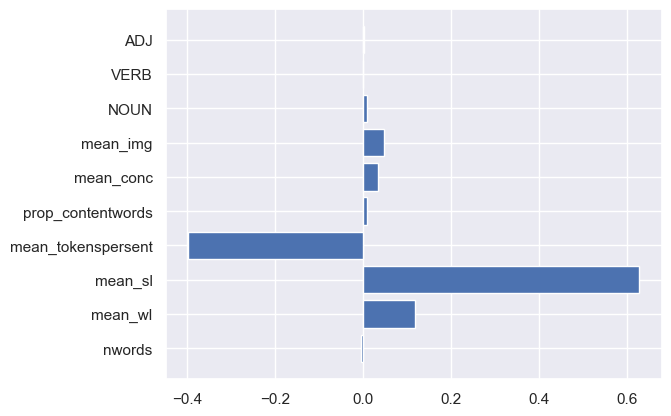

In [16]:
display_df = pd.DataFrame(reg.coef_.T, index=xdf.columns)
display(display_df)

import matplotlib.pyplot as plt

plt.barh(display_df.index,display_df[0])

In [1]:
from madhatter.utils import get_imageability_df

get_imageability_df()

,item,rt,sd_rt,num,rating,sd_rating,toglia
0,ace,1363.0,654.0,29,4.5,2.7,NaN
1,ache,1439.7,640.3,30,3.8,2.3,NaN
2,act,1388.6,787.7,31,3.5,2.3,4.31
3,ad,1237.3,812.4,28,4.1,2.6,NaN
4,add,1287.3,606.3,30,3.3,2.2,NaN
...,...,...,...,...,...,...,...
2995,zing,1128.3,814.6,30,2.3,1.9,NaN
2996,zip,1318.8,679.4,29,5.1,2.2,NaN
2997,zone,1227.5,871.1,31,4.1,2.5,4.56
2998,zoo,966.5,329.5,30,6.8,0.6,6.07


- Write about lemmatization approaches
- Possibly make a diagram for how the process goes

In [1]:
import pathlib
import os.path